In [1]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt

/Users/kennonstewart/iq/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Analyzing the Complexity of Urban Road Networks

The goal of this project is to profile the structural complexity of different urban road networks.

The goal is to describe the motifs of road networks with high complexity. Specifically, what makes one road network quantifiably more complex than another?

In order to answer this question, we first have to have some data. And not just any data, but and ultra-clean network-structured dataset that encodes road information. This graph encoding will need to support compression, MDL estimation, and eventually display for my website.

In [2]:
# Define place name or coordinates
places = [
    "Manhattan, New York, USA",
    "San Francisco, California, USA",
    "Detroit, Michigan, USA",
    "Chicago, Illinois, USA",
    "Los Angeles, California, USA",
    "Washington, D.C., USA",
    "Seattle, Washington, USA",
    "Miami, Florida, USA",
]

map_data = {}
for place in places:
    # Extract network within bounding box or boundary
    G = ox.graph_from_place(place, network_type='drive')
    map_data[place] = G


The first thing I wanna do is take a look at the data we're seeing here. We have Manhattan, SF, Detroit, Chicago, LA, DC, Seattle, and Miami. Each of these geographies has their quirks (Detroit's administrative boundaries include two intentionally segregated cities, Seattle and SF are hopelessly strewn across hillsides, and Chicago has that damn grid).

I'd like to see the amount of information encoded before and after our cleaning process. The difference indicates the amount of extraneous information that was stripped during cleaning. This information would ideally be non-topological so as to keep the important road data.

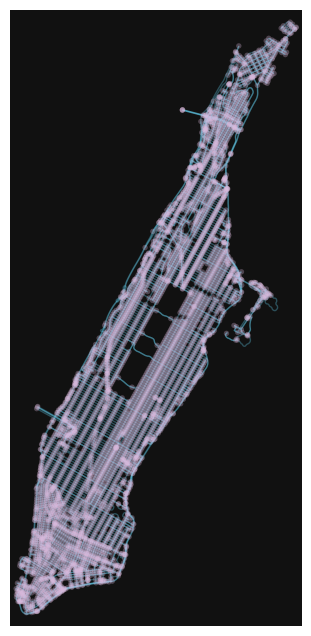

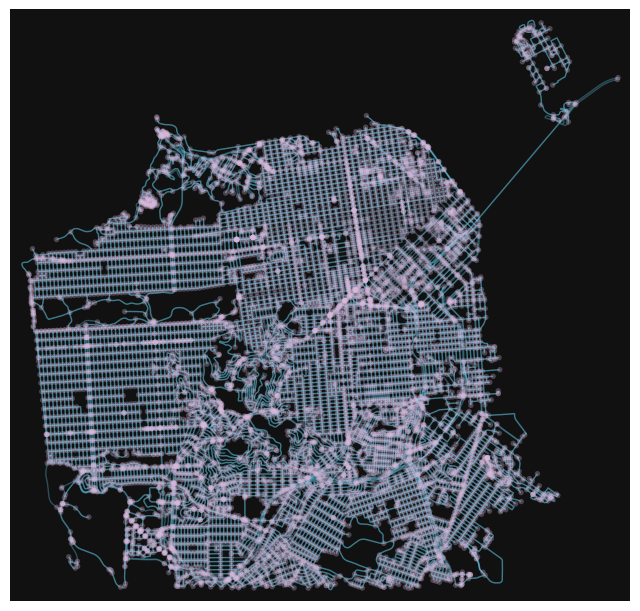

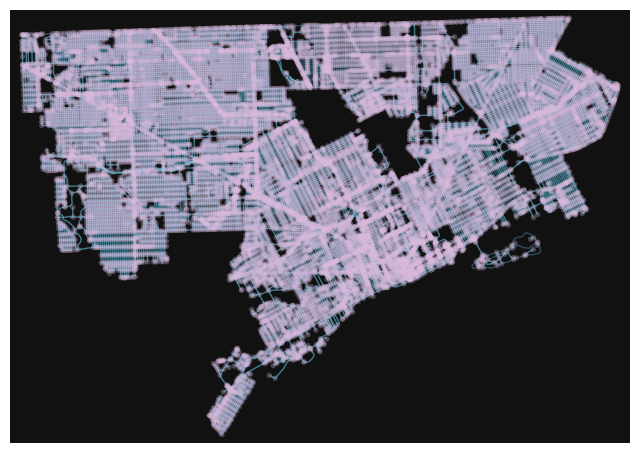

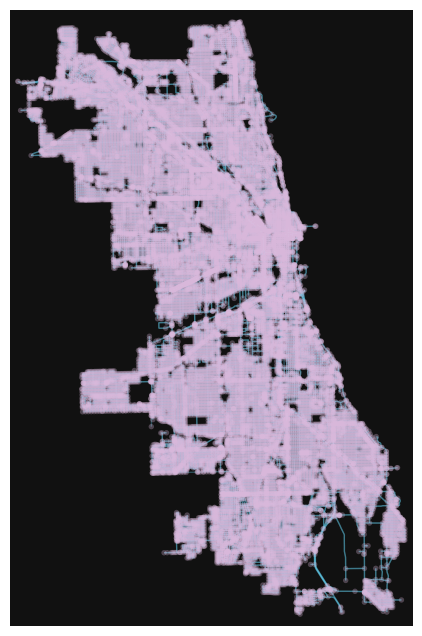

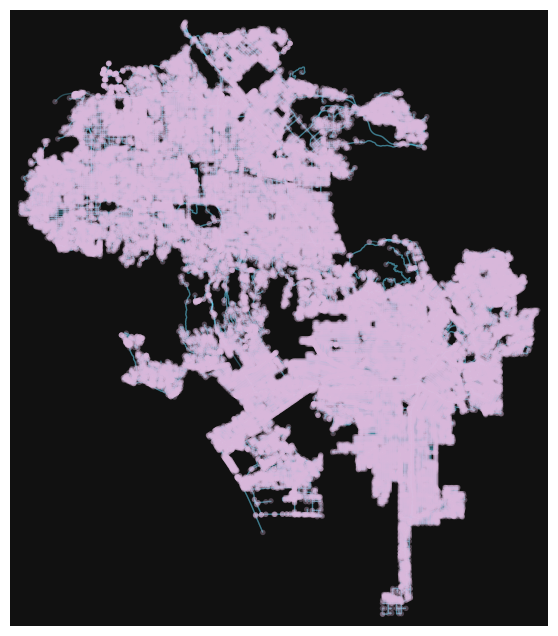

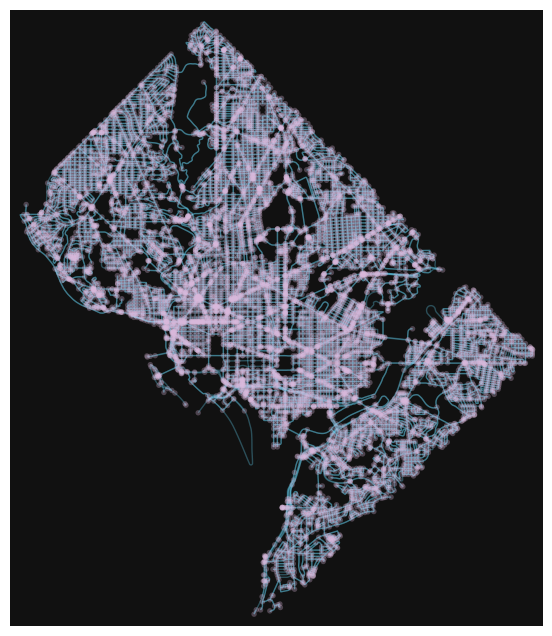

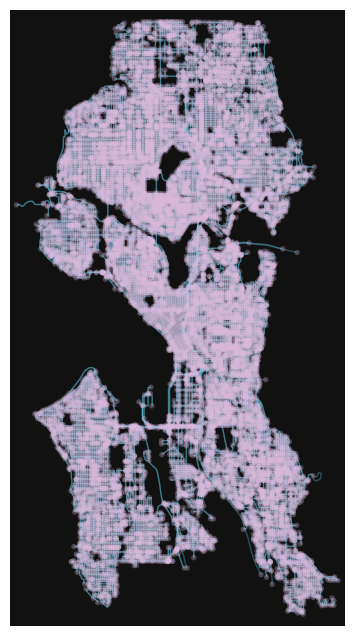

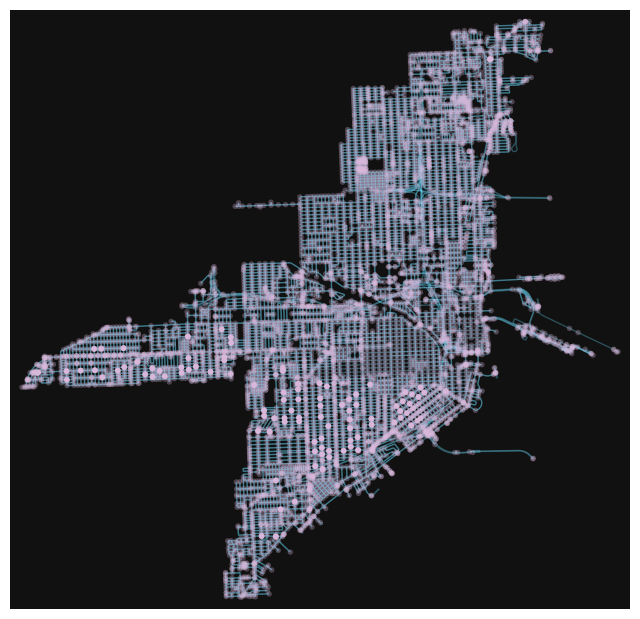

In [ ]:
for place in map_data:
    G = map_data[place]
    ox.plot_graph(G,
        bgcolor="#111111",
        node_color="#DBBADD",
        node_size=15,
        node_alpha=0.3,
        node_edgecolor="none",
        node_zorder=1,
        edge_color="#69DDFF",
        edge_alpha=0.3
    )
    # save figure
    plt.savefig(f"{place}_map.png", dpi=300)
    plt.close()
    # clean the data
    try: 
        G_simplified = ox.simplification.simplify_graph(G)
        G_proj = ox.project_graph(G)
        G_std = ox.convert.graph_to_gdfs(G_proj, nodes=True, edges=True)
        map_data[place] = G_std
    except:
        G_proj = ox.project_graph(G)
        G_std = ox.convert.graph_to_gdfs(G_proj, nodes=True, edges=True)
        map_data[place] = G_std
        
    # generate canonical representations
    filename = f"{place}"
    nx.write_adjlist(G, str(filename) + ".adjlist")
    g6 = nx.to_graph6_bytes(nx.Graph(G), header=False)
    with open(str(filename) + ".g6", "wb") as f:
        f.write(g6)
    nx.write_edgelist(G, str(filename) + ".edgelist", data=False)